In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
sift = cv2.SIFT_create()

# Helper Functions

In [2]:
def transform_2D(img, H):
    in_row, in_col = img.shape

    input_points = np.stack(np.meshgrid(np.arange(in_row), np.arange(in_col), indexing='ij'), axis=-1).reshape(-1, 2)
    output_points = input_points @ H.T

    row_min, col_min = np.floor(output_points.min(axis=0)).astype(int)
    output_points -= [row_min, col_min]
    row_max, col_max = np.ceil(output_points.max(axis=0)).astype(int)
    output_image = np.zeros((row_max + 1, col_max + 1))

    output_points = output_points.astype(int)
    output_image[output_points[:, 0], output_points[:, 1]] = img[input_points[:, 0], input_points[:, 1]]

    return output_image

def transform_3D(img, H, z_axis = None):
    z_tilde = 1

    rows, cols = img.shape
    input_points = np.stack(np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij'), axis=-1).reshape(-1, 2)
    if z_axis is None:
        input_points = np.hstack((input_points, z_tilde * np.ones((input_points.shape[0], 1))))

    else:
        z_axis = z_axis.reshape(-1, 1) if z_axis.ndim == 1 else z_axis
        input_points = np.hstack((input_points, z_axis))

    output_points = input_points @ H.T
    normalized_points = output_points[:, :2] / output_points[:, 2, np.newaxis]

    output = np.floor(normalized_points).astype(int)

    x_min, y_min = output.min(axis=0)
    x_max, y_max = output.max(axis=0)
    
    shift_x, shift_y = max(0, -x_min), max(0, -y_min)
    output += [shift_x, shift_y]
    
    out_rows = max(0, x_max + shift_x) + 1
    out_cols = max(0, y_max + shift_y) + 1
    output_image = np.zeros((out_rows, out_cols))

    valid_mask = (output[:, 0] >= 0) & (output[:, 0] < out_rows) & (output[:, 1] >= 0) & (output[:, 1] < out_cols)
    output_image[output[valid_mask, 0], output[valid_mask, 1]] = img[input_points[valid_mask, 0].astype(int), input_points[valid_mask, 1].astype(int)]

    return output_image

def transform_3D2(img, H, z_axis = None):
    z_tilde = 1
    if z_axis is None:
        input_points = np.array([[i,j,z_tilde] for i in range(img.shape[0]) for j in range(img.shape[1])])
    if z_axis is not None:
        input_points = np.array([[i,j] for i in range(img.shape[0]) for j in range(img.shape[1])])
        input_points = np.concatenate((input_points, z_axis), axis=1)
    output_points = input_points @ H.T
    normalised = output_points / output_points[:,2].reshape(-1,1)
    output = normalised[:,:-1].astype(int)

    x_min, y_min = np.min(output[:,0]), np.min(output[:,1])
    x_max, y_max = np.max(output[:,1]), np.max(output[:,1])
    out_rows, out_cols = np.max(output[:,0]), np.max(output[:,1])

    if x_min < 0:
        out_rows -= x_min
    if y_min < 0:
        out_cols -= y_min
    output_image = np.zeros((out_rows+1, out_cols+1))
    
    for inp, out in zip(input_points, output):
        output_image[out[0], out[1]] = img[inp[0], inp[1]]

    return output_image

In [3]:
path = "/home/arnabdey/Placement_ML_projects/Principles of CV/images/Furnitures.jpg"
image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY) / 255.0

# 2D transform

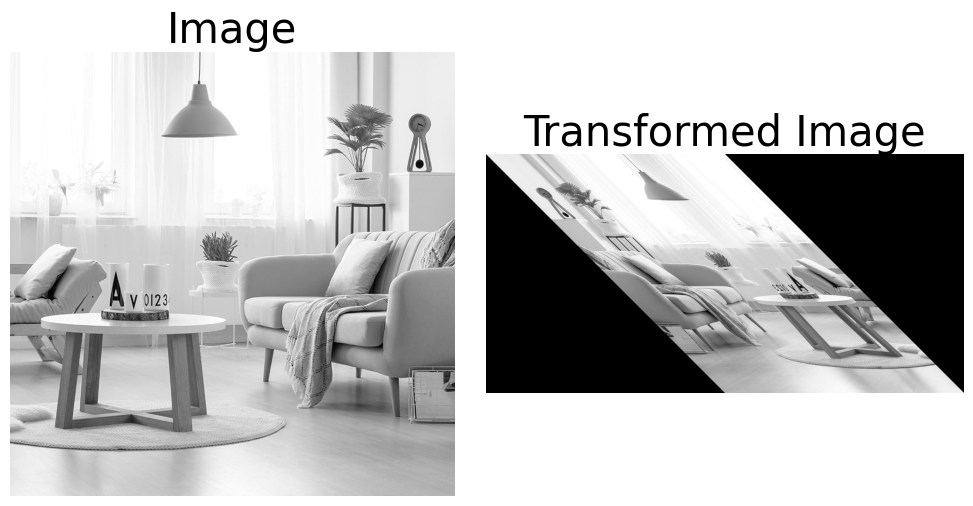

In [4]:
H = np.array([[1, 0], 
              [1, -1]])
out2 = transform_2D(img=image, H=H)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Image", fontsize=30)
axes[1].imshow(out2, cmap='gray')
axes[1].set_title("Transformed Image", fontsize=30)
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

# 3D Transform

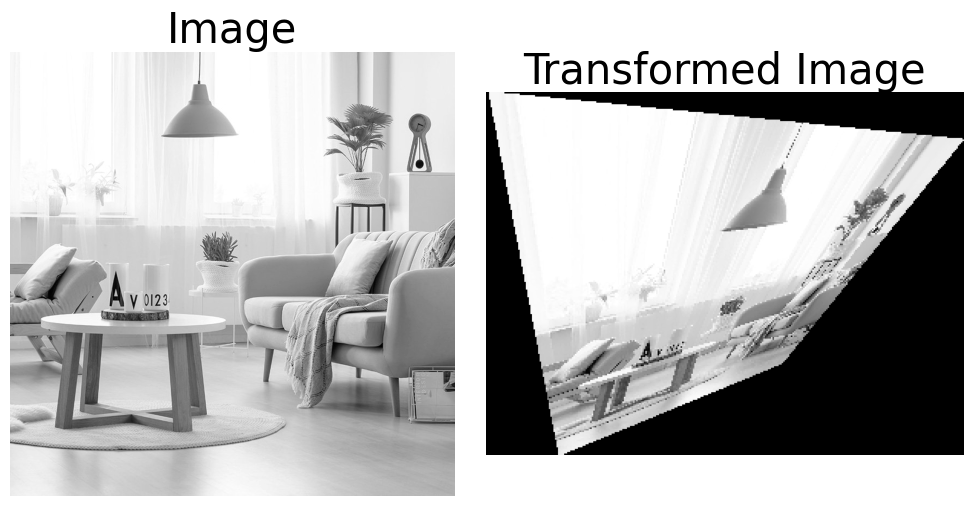

In [5]:
H = np.array([[1, .1, .005],
              [0.2, 1, 2],
              [0.003, .002, 1]])
out3 = transform_3D(img=image, H=H, z_axis=None)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Image", fontsize=30)
axes[1].imshow(out3, cmap='gray')
axes[1].set_title("Transformed Image", fontsize=30)
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

# Stitching

In [6]:
def getCommonKeypoints(image_1, image_2, top_k = 20):
    sift = cv2.SIFT_create()
    kp_1, des_1 = sift.detectAndCompute(image_1, None)
    kp_2, des_2 = sift.detectAndCompute(image_2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des_1, des_2)
    matches = sorted(matches, key=lambda x: x.distance)[:top_k]
    
    matched_points_1 = np.array([(kp_1[m.queryIdx].pt[1], kp_1[m.queryIdx].pt[0]) for m in matches])
    matched_points_2 = np.array([(kp_2[m.trainIdx].pt[1], kp_2[m.trainIdx].pt[0]) for m in matches])

    return matched_points_1, matched_points_2
def createTransformMatrix_H(source_image, destination_image):
    pairs = []
    for source_point, dest_point in zip(source_image, destination_image):
        x_s, y_s = source_point.astype(int)
        x_d, y_d = dest_point.astype(int)
        pair = np.array([
            [x_s, y_s, 1, 0, 0, 0, -x_d * x_s, -x_d * y_s, -x_d],
            [0, 0, 0, x_s, y_s, 1, -y_d * x_s, -y_d * y_s, -y_d]
        ])
        pairs.append(pair)
    pairs = np.array(pairs).reshape(-1, 9)
    A = pairs
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)

    # eig_vals, eig_vects = np.linalg.eigh(A.T @ A)
    # min_index = np.argmin(eig_vals)
    # H = eig_vects[:, min_index].reshape(3, 3)
    return H
def find_and_plot_matches_with_pixel_indices(image_1, image_2, k=10):
    orb = cv2.ORB_create()

    keypoints1, descriptors1 = orb.detectAndCompute(image_1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(image_2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    matches = sorted(matches, key=lambda x: x.distance)
    top_k_matches = matches[:k]

    pixel_coords_img1 = [(int(keypoints1[match.queryIdx].pt[0]), int(keypoints1[match.queryIdx].pt[1])) for match in top_k_matches]
    pixel_coords_img2 = [(int(keypoints2[match.trainIdx].pt[0]), int(keypoints2[match.trainIdx].pt[1])) for match in top_k_matches]

    return pixel_coords_img1, pixel_coords_img2

def stitch_images(image_1, image_2, k=20):
    indices_img1, indices_img2 = find_and_plot_matches_with_pixel_indices(image_1, image_2, k=k)
    indices_img1 = np.array(indices_img1)[:,::-1]
    indices_img2 = np.array(indices_img2)[:,::-1]

    H = createTransformMatrix_H(source_image=indices_img1, destination_image=indices_img2)

    z_tilde = 1
    input_points_1 = np.array([[i, j, z_tilde] for i in range(image_1.shape[0]) for j in range(image_1.shape[1])])
    input_points_2 = np.array([[i, j, z_tilde] for i in range(image_2.shape[0]) for j in range(image_2.shape[1])])
    output_points_1 = input_points_1 @ H.T
    output_points_1 = output_points_1 / output_points_1[:,2].reshape(-1,1)

# output_points_1 = np.clip(output_points_1, -100, 3000).astype(int)
    output_points_1 = output_points_1.astype(int)
    output_points_2 = input_points_2.astype(int)
    
    # return input_points_1, input_points_2, output_points_1, output_points_2

    x_min, x_max = min(np.min(output_points_1[:,0]), np.min(output_points_2[:,0])), max(np.max(output_points_1[:,0]), np.max(output_points_2[:,0]))
    y_min, y_max = min(np.min(output_points_1[:,1]), np.min(output_points_2[:,1])), max(np.max(output_points_1[:,1]), np.max(output_points_2[:,1]))

    output_points_1[:,0] -= x_min
    output_points_2[:,0] -= x_min
    output_points_1[:,1] -= y_min
    output_points_2[:,1] -= y_min

    x_max = max(np.max(output_points_1[:,0]), np.max(output_points_2[:,0]))
    y_max = max(np.max(output_points_1[:,1]), np.max(output_points_2[:,1]))
    output_shape = (x_max + 1, y_max + 1)
    output_image = np.zeros(output_shape)

    for inp, out in zip(input_points_1, output_points_1):
        output_image[out[0], out[1]] = image_1[inp[0], inp[1]]
    for inp, out in zip(input_points_2, output_points_2):
        output_image[out[0], out[1]] = image_2[inp[0], inp[1]]
    return indices_img1, indices_img2, output_image

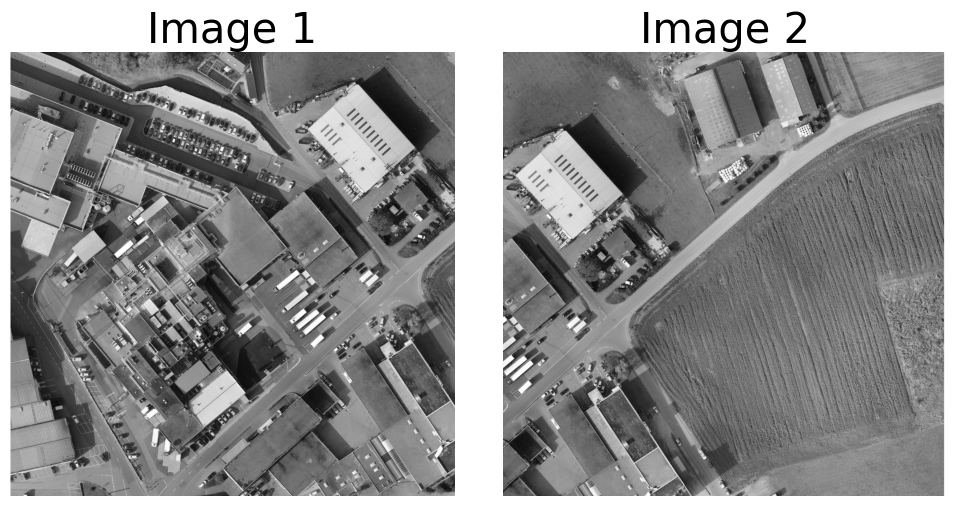

In [7]:
image_1 = cv2.cvtColor(cv2.imread("/home/arnabdey/Placement_ML_projects/Principles of CV/images/2.jpg"), cv2.COLOR_BGR2GRAY)
image_2 = cv2.cvtColor(cv2.imread("/home/arnabdey/Placement_ML_projects/Principles of CV/images/4.jpg"), cv2.COLOR_BGR2GRAY)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(image_1, cmap='gray')
axes[0].set_title("Image 1", fontsize=30)
axes[1].imshow(image_2, cmap='gray')
axes[1].set_title("Image 2", fontsize=30)
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [8]:
pix_coord_1, pix_coord_2, output = stitch_images(image_1=image_1, image_2=image_2)

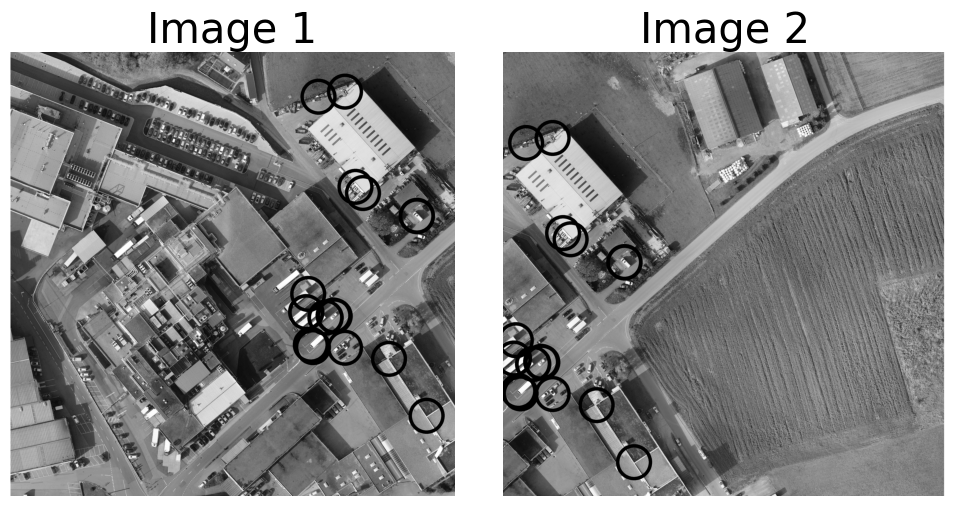

In [9]:
image_1_copy = image_1.copy()
image_2_copy = image_2.copy()
for x, y in pix_coord_1:
    x, y = int(x), int(y)
    cv2.circle(image_1_copy, (y, x), radius=100, color=(0, 80, 255), thickness=20)
for x, y in pix_coord_2:
    x, y = int(x), int(y)
    cv2.circle(image_2_copy, (y, x), radius=100, color=(0, 80, 255), thickness=20)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(image_1_copy, cmap='gray')
axes[0].set_title("Image 1", fontsize=30)
axes[1].imshow(image_2_copy, cmap='gray')
axes[1].set_title("Image 2", fontsize=30)
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

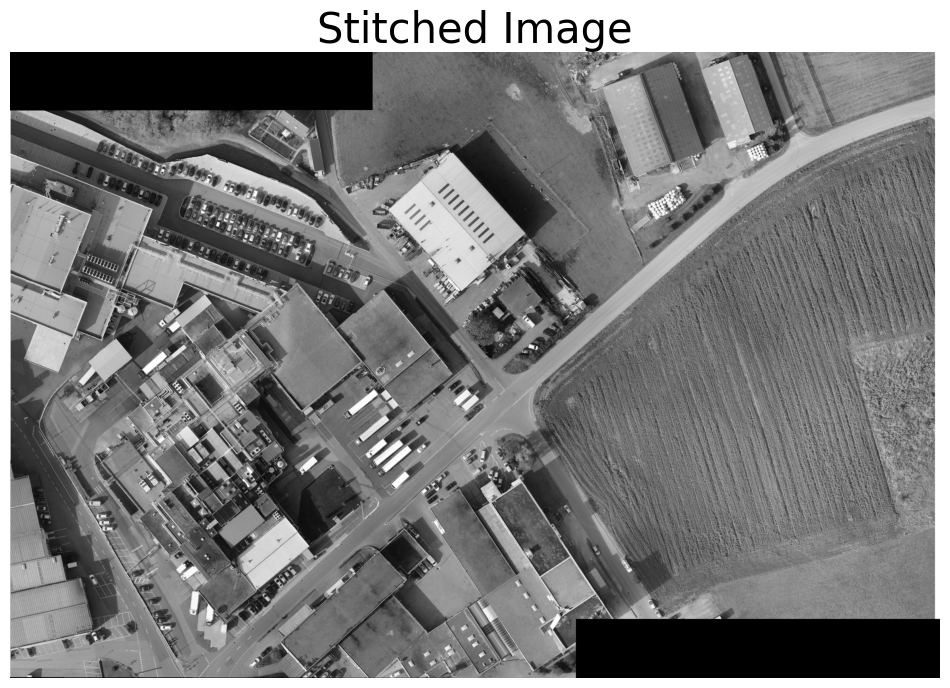

In [16]:
plt.figure(figsize=(12, 12))
plt.imshow(output, cmap='gray')
plt.axis('off')
plt.title("Stitched Image", fontsize=30)
plt.show()